In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import partition_igraph
from matplotlib import pyplot as plt
from matplotlib import colormaps
import matplotlib.colors as colors
import random
import pickle
import os
import seaborn as sns
import time
import csv
import subprocess
from itertools import combinations
import scipy.sparse as sparse 


## ABCD-oo graphs

Steps to generate the required ABCD-oo graph for this experiment:

#### (1) install ABCDoo from https://github.com/bkamins/ABCDGraphGenerator.jl 

The code is currently in its own branch. In Julia, run the following:
```
using Pkg
Pkg.add(PackageSpec(url="https://github.com/bkamins/ABCDGraphGenerator.jl", rev="bk/overlapping_communities"))
exit()
```

#### (2) generate the graphs by running:

```julia ./abcdoo_graph_sampler.jl```

#### (3) save the graph files and point to the correct folder in the next cell

We use filename format: ```abcdoo_xi_eta_n_edge.dat``` and ```abcdoo_xi_eta_n_com.dat```

#### (4) install and compile the Overlapping-NMI code

We use the version from: ```https://github.com/aaronmcdaid/Overlapping-NMI```

Point to the executable in the next cell


In [2]:
## point to the ABCDoo graph datasets
path = './Datasets/abcdoo_'

## overlapping NMI executable
oNMI = './onmi'          


In [3]:
## read a graph and store is igraph object
def readGraph(xi=0.5, eta=1.5, n=5000):
    ## read edges, build graph
    fn = path+str(xi)+'_'+str(eta)+'_'+str(n)+'_edge.dat'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1 ## map to 0-based
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+str(xi)+'_'+str(eta)+'_'+str(n)+'_com.dat'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G
   

In [4]:
## compute Overlapping-NMI
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x


## Simple implementations of a few algorithms to find overlapping communities

* Clique percolation (CPM)
* Ego Split
* Ego Split + IEF
* Edge clustering


In [5]:
## Simple implementations of a few algorithms to find overlapping communities

def CPM(g, k=3):
    cls = list(map(set, g.cliques(min=k,max=k)))
    edgelist = []
    for i in range(len(cls)):
        edgelist.append((i,i))
    for i,j in combinations(range(len(cls)),2):
        if len(cls[i].intersection(cls[j])) >= (k-1):
            edgelist.append((i,j))
    cg = ig.Graph(edgelist, directed=False)
    clusters = cg.connected_components()
    L = []
    for cluster in clusters:
        members = set()
        for i in cluster:
            members.update(cls[i])
        L.append(set(g.vs[members]["name"]))
    return L

def EgoSplit(G, split='CC', algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP or ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-net splits
    for nm in names:
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        if split == 'LP':
            x = sg.community_label_propagation().membership
        else:
            x = sg.connected_components().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32)
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C

def IEF(G, ES, thresh=0.25):
    C = sparse.csc_matrix((G.vcount(),len(ES)))
    C.indices = np.array([int(i) for j in ES for i in j])
    C.data = np.repeat(1,len(C.indices))
    ptr = [0]
    ctr = 0
    for x in ES:
        ctr += len(x)
        ptr.append(ctr)
    C.indptr = np.array(ptr)
    M = C.tocsr()

    ## IEF
    A = G.get_adjacency_sparse()
    Degrees = np.array(A.sum(axis=1)).flatten()
    DegA = A*M
    DegInv = sparse.diags(1/Degrees).tocsr()
    IEF = DegInv*DegA

    L = []
    for i in range(IEF.shape[1]):
        x = np.where( (np.array(IEF[:,i].todense()).flatten() >= thresh))[0]
        if len(x)>0:
            L.append(list(x))        
    return L
    
def Jaccard(a,b):
    x = len(set(a).intersection(set(b)))/len(set(a).union(set(b)))
    return x

def weightedLinegraph(g):
    lg = g.linegraph()
    w=[]
    for e in lg.es:
        A = set(g.es[e.tuple[0]].tuple)
        B = set(g.es[e.tuple[1]].tuple)
        x = list((A-B).union(B-A))
        w.append(Jaccard(g.neighbors(x[0]),g.neighbors(x[1])))
    lg.es['weight'] = w
    return lg

def edgeCluster(g, color=False):
    q = -999
    D = weightedLinegraph(g)
    for th in sorted(set(D.es['weight'])):
        ## filter edges w.r.t. similarity and find CC
        dg = D.copy()
        dg.delete_edges([e for e in dg.es if e['weight']<=th])
        cc = dg.connected_components().membership
        mod = D.modularity(cc)
        if mod>q:
            q = mod
            g.es['lc'] = cc
            if color:
                pal = ig.ClusterColoringPalette(n=max(cc)+1)
                for e in g.es:
                    e['color'] = pal[e['lc']]
    ## Now gather the nodes for each edge cluster
    L = []
    for i in range(max(g.es['lc'])+1):
        sg = g.subgraph_edges([e for e in g.es if e['lc']==i])
        L.append(sg.vs['name'])
    return L

## given list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L
    

## Quick sanity test

In [6]:
## read graph
G = readGraph(xi=0.1, eta=1.25, n=1000)
G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
GT = mems2comms(G.vs['comms'])[1:]  ## no "outlier community"
GT = [[str(i) for i in x] for x in GT]


In [7]:
## run a few algorithms
random.seed(123)
np.random.seed(123)

a = time.time()
Comms = CPM(G)
print('CPM done, time:',time.time()-a,' oNMI:', compute_oNMI(Comms, GT))

a = time.time()
LD = mems2comms([[x] for x in G.community_leiden(objective_function='modularity').membership])
Comms = [[str(i) for i in j] for j in LD]
print('Leiden done, time:',time.time()-a,' oNMI:', compute_oNMI(Comms, GT))

a = time.time()
comms_es = EgoSplit(G, split='CC', algo='ECG')
Comms = ES = [list(x) for x in comms_es if len(x)>=10]
print('EgoSplit done, time:',time.time()-a,' oNMI:', compute_oNMI(Comms, GT))

a = time.time()
Comms = IEF(G, ES, thresh=0.25)
print('IEF done, time:',time.time()-a,' oNMI:', compute_oNMI(Comms, GT))

a = time.time()
EC = edgeCluster(G)
Comms = [x for x in EC if len(x) >= 10]
print('Edge clustering done, time:',time.time()-a,' oNMI:', compute_oNMI(Comms, GT))


CPM done, time: 9.928360223770142  oNMI: 0.0056772
Leiden done, time: 0.006020069122314453  oNMI: 0.465641
EgoSplit done, time: 4.161130428314209  oNMI: 0.46244
IEF done, time: 0.007598876953125  oNMI: 0.635216
Edge clustering done, time: 274.4266707897186  oNMI: 0.19317


## Compare algorithms for fixed $n$ (number of nodes)

* CPM
* Leiden
* Ego-Split
* EgoSplit+IEF
* Edge clustering

Uncomment the cell below to run - results stored in a pkl file.


In [8]:
with open('Results/algo_compare.pkl','rb') as fp:
    df = pickle.load(fp)
df.columns = ['eta', 'xi', 'CPM', 'Leiden', 'EgoSplit', 'EgoSplit+Beta', 'EgoSplit+IEF','Edge']
df.head()


,eta,xi,CPM,Leiden,EgoSplit,EgoSplit+Beta,EgoSplit+IEF,Edge
0,1.00,0.1,0.907846,0.992493,0.937675,0.998995,0.999366,0.814815
1,1.25,0.1,0.004925,0.244036,0.419068,0.544411,0.540569,0.057054
2,1.50,0.1,0.003688,0.086664,0.148121,0.251391,0.255151,0.034033
3,1.75,0.1,0.005036,0.097390,0.064283,0.148695,0.152747,0.008098
4,2.00,0.1,0.005078,0.099440,0.044486,0.113115,0.112735,0.013593


## Plots for ABCD-oo paper

In [9]:
cmap = colormaps.get_cmap('mako')
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = truncate_colormap(cmap,0,.85)


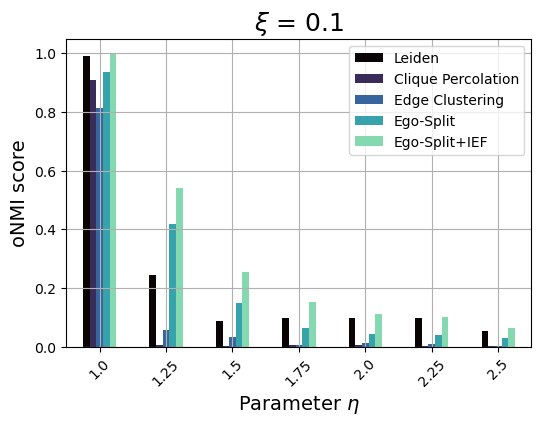

In [10]:
df[df.xi==.1].plot(x='eta',y=['Leiden', 'CPM', 'Edge', 'EgoSplit', 'EgoSplit+IEF'], 
                    kind='bar', figsize=(6,4), colormap=cmap)
plt.grid()
plt.legend(['Leiden','Clique Percolation','Edge Clustering','Ego-Split','Ego-Split+IEF'])
plt.xlabel(r'Parameter $\eta$', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('oNMI score', fontsize=14)
plt.title(r'$\xi$ = 0.1', fontsize=18);
#plt.savefig('compare_algos_eta.png', bbox_inches='tight');


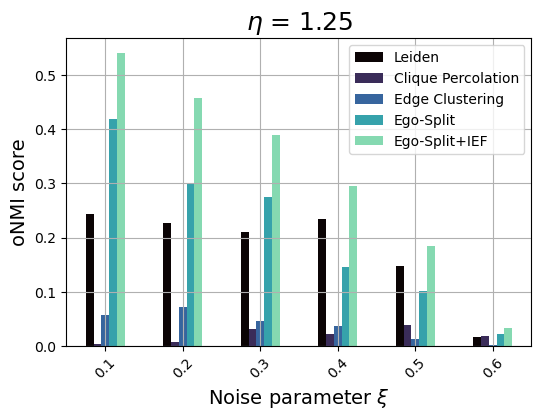

In [11]:
df[df.eta==1.25].plot(x='xi',y=['Leiden', 'CPM', 'Edge', 'EgoSplit', 'EgoSplit+IEF'], 
                     kind='bar', figsize=(6,4), colormap=cmap);
plt.grid()
plt.legend(['Leiden','Clique Percolation','Edge Clustering','Ego-Split','Ego-Split+IEF'])
plt.xlabel(r'Noise parameter $\xi$', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('oNMI score', fontsize=14)
plt.title(r'$\eta$ = 1.25', fontsize=18);
#plt.savefig('compare_algos_xi.png', bbox_inches='tight');


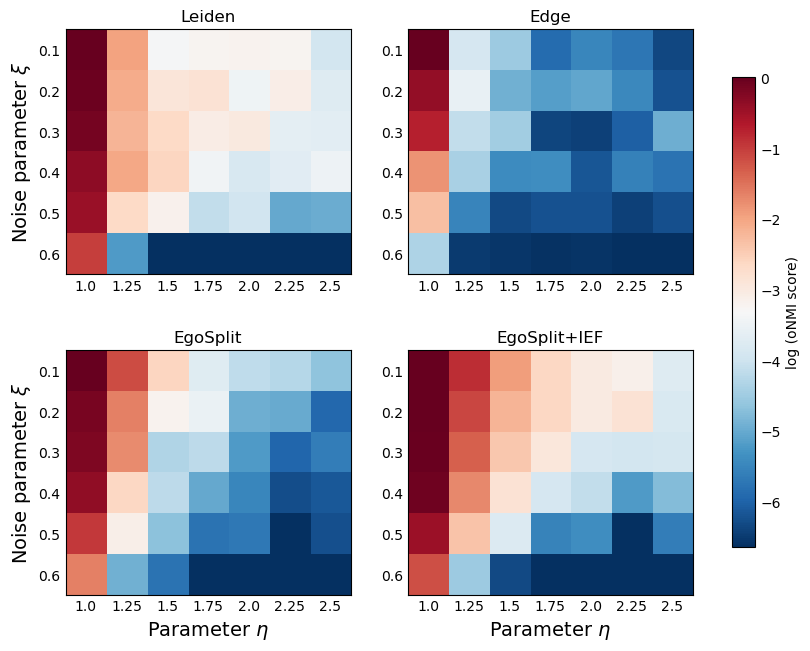

In [12]:
## image plot
plt.style.use('_mpl-gallery-nogrid')

# make data
X = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
Y = [1.0,1.25,1.5,1.75,2.0,2.25,2.5]
Scores = []
Cases = ['Leiden', 'Edge', 'EgoSplit', 'EgoSplit+IEF']
for k in range(4):
    Z = np.zeros((len(X),len(Y)))
    score = df[Cases[k]]
    ctr = 0
    for i in range(len(X)):
        for j in range(len(Y)):
            Z[i,j] = np.log2(0.01+score[ctr])
            ctr += 1    
    Scores.append(Z)

# plot
fig, axs = plt.subplots(2, 2, figsize=(8,6))
ctr = 0
cmaps = ['RdBu_r', 'viridis']
for row in range(2):
    for col in range(2):
        ax = axs[row, col]
        pcm = ax.imshow(Scores[ctr], cmap=cmaps[0])
        ax.set_title(Cases[ctr])
        ax.set_yticks(ticks=[0,1,2,3,4,5],labels=X)
        ax.set_xticks(ticks=[0,1,2,3,4,5,6],labels=Y);
        if row==1:
            ax.set_xlabel(r'Parameter $\eta$', fontsize=14)
        if col==0:
            ax.set_ylabel(r'Noise parameter $\xi$', fontsize=14)
        ctr += 1
fig.colorbar(pcm, ax=axs[:, :], shrink=0.8, label='log (oNMI score)');
#plt.savefig('compare_algos_grid.png', bbox_inches='tight');


## Compare algorithms for varying $n$ (number of nodes)

* CPM
* Leiden
* Ego-Split
* EgoSplit+IEF
* Edge clustering

Uncomment the cell below to run - results stored in a pkl file.


In [13]:
with open('Results/algo_compare_time.pkl','rb') as fp:
    df = pickle.load(fp)
df.columns = ['n', 'CPM', 'Leiden', 'EgoSplit', 'IEF', 'Edge']
df['IEF'] = df['EgoSplit']+df['IEF'] ## IEF required EgoSplit results


In [17]:
df.tail()

,n,CPM,Leiden,EgoSplit,IEF,Edge
10,11000,170.565465,0.026066,349.924413,351.089929,949.091300
11,12000,229.888624,0.028539,412.172068,413.583854,1131.448813
12,13000,272.361212,0.030378,469.316938,470.675116,1263.216173
13,14000,299.457273,0.033064,555.299773,556.764773,1514.637123
14,15000,347.310731,0.042629,653.508991,655.120777,1566.801498


## Plot for ABCD-oo paper


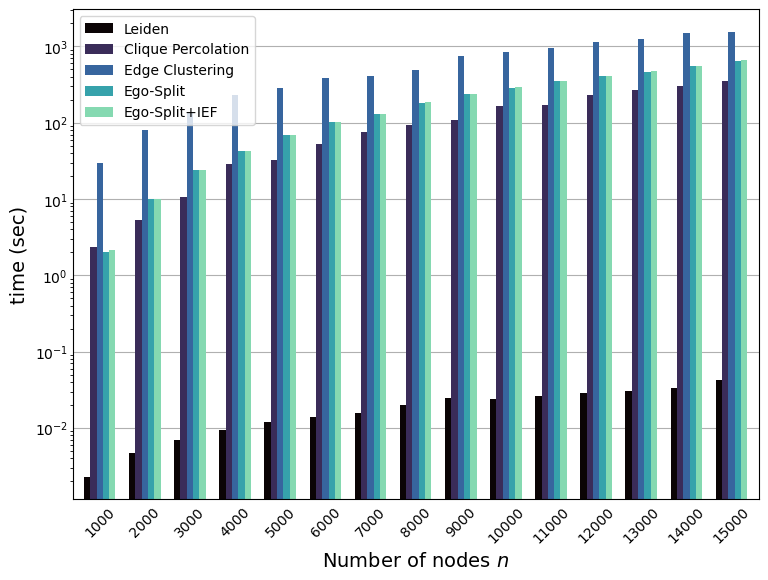

In [15]:
df.plot(x='n',y=['Leiden', 'CPM', 'Edge', 'EgoSplit', 'IEF'], 
                    kind='bar', figsize=(7,5), colormap=cmap, logy=True, width=.7)
plt.grid(axis='y')
plt.legend(['Leiden','Clique Percolation','Edge Clustering','Ego-Split','Ego-Split+IEF'])
plt.xlabel(r'Number of nodes $n$', fontsize=14)
plt.ylabel('time (sec)', fontsize=14)
plt.xticks(rotation=45);
#plt.savefig('compare_algos_time.png', bbox_inches='tight');
